In [1]:
from torch_TICLNet_layerPool import *
from helper_DataLoader import *

from IPython.display import clear_output
%matplotlib inline

# 1. Initialization

In [2]:
# load training dataset
testset = TICLNetDataset('../data/pickle/test_layerPool.pkl')
# initialize a model
model = TICLNet_layerPool()
model.load_state_dict(torch.load('../data/model/TICLNet_layerPool.dict'))
model.eval()

TICLNet_layerPool(
  (conv): Sequential(
    (0): Conv1d(1, 4, kernel_size=(5,), stride=(1,))
    (1): ReLU(inplace)
    (2): Conv1d(4, 4, kernel_size=(4,), stride=(2,))
    (3): ReLU(inplace)
    (4): Conv1d(4, 4, kernel_size=(4,), stride=(1,))
    (5): ReLU(inplace)
  )
  (fc): Sequential(
    (0): Linear(in_features=80, out_features=16, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)

# 2. Testing

In [4]:
softmax = []
for i in range(len(testset)):
    event = testset[i]
    X = torch.tensor(event["feature"])
    Y = torch.tensor(event["label"])
    y = F.softmax(model(X),dim=1)
    softmax.append(y.data.numpy())
softmax = np.array(softmax)  
softmax = softmax.reshape(-1,4)

In [5]:
labels = np.array(testset.label)

# 3. Plot Result

In [6]:
predMatrix = np.zeros([4,4])

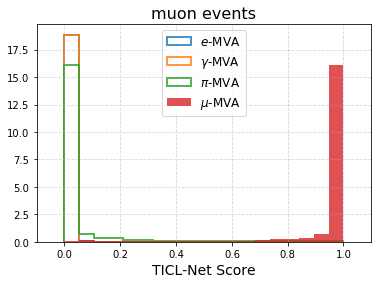

In [24]:
particle = 3
temp_softmax = softmax[labels==particle]

# prepare making plot
mvaBins = np.linspace(0,1,20)
mvaLabels = [r'$e$-MVA',r'$\gamma$-MVA',r'$\pi$-MVA',r'$\mu$-MVA']
particleName = ['electron','photon','pion','muon']

# make plot
plt.figure(facecolor='w')
for i in range(4):
    if i == particle:
        htype = 'stepfilled'
        halpha = 0.8
    else:
        htype = 'step'
        halpha = 0.8
    plt.hist(temp_softmax[:,i], mvaBins,
             normed=True,alpha = halpha,
             lw=2, histtype=htype,label=mvaLabels[i])
    
plt.legend(loc='upper center',fontsize=12)
plt.grid(linestyle='--',alpha=0.5)
plt.xlim(-0.1,1.1)
plt.xlabel('TICL-Net Score',fontsize=14)
plt.title('{} events'.format(particleName[particle]),fontsize=16)
plt.savefig('../plots/score/mva_{}.png'.format(particleName[particle]),dpi=200)

In [25]:
predicts = np.argmax(temp_softmax,axis=1)
h,b= np.histogram(predicts, bins=np.arange(5))
predMatrix[particle,:]=h/len(predicts)

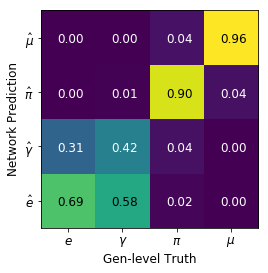

In [26]:
# show predicts
plt.figure(facecolor='w')
plt.imshow(predMatrix.T,origin='lower')
plt.xlabel('Gen-level Truth',fontsize=12)
plt.ylabel('Network Prediction',fontsize=12)
plt.xticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\pi$',r'$\mu$'],fontsize=12)
plt.yticks(np.arange(4),[r'$\hat{e}$',r'$\hat{\gamma}$',r'$\hat{\pi}$',r'$\hat{\mu}$'],fontsize=12)

for i in range(4):
    for j in range(4):
        clr = 'w'
        val = predMatrix[i,j]
        if val >0.5:
            clr = 'k'
        plt.text(i-0.2,j-0.1,'{:4.2f}'.format(val), color=clr,fontsize=12)

plt.savefig('../plots/score/accuracy.png',dpi=200)

# convert to pb

In [7]:
import torch.onnx
import onnx
from onnx_tf.backend import prepare

# ticlnet_rnn = model.rnn
# rnn_input = torch.randn(1, 3)
# torch.onnx.export(ticlnet_rnn, rnn_input, "ticlnet_rnn.onnx", verbose=True )

ticlnet_cnn = model
cnn_input = torch.randn(10, 1, 52)
torch.onnx.export(ticlnet_cnn, cnn_input, "../data/model/ticlnet_layerPool.onnx", verbose=True )

/Users/zihengchen/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/zihengchen/Downloads/onnx-tensorflow/onnx_tf/common/__init__.py:87: UserWarning: onnx_tf.common.get_outputs_names is deprecated. It will be removed in future release. Use TensorflowGraph.get_outputs_names instead.
  warnings.warn(message)



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

graph(%0 : Float(10, 1, 52)
      %1 : Float(4, 1, 5)
      %2 : Float(4)
      %3 : Float(4, 4, 4)
      %4 : Float(4)
      %5 : Float(4, 4, 4)
      %6 : Float(4)
      %7 : Float(16, 80)
      %8 : Float(16)
      %9 : Float(4, 16)
      %10 : Float(4)) {
  %11 : Tensor = onnx::Constant[value= -1   1  52 [ CPULongType{3} ]](), scope: TICLNet_layerPool
  %12 : Float(10, 1, 52) = onnx::Reshape(%0, %11), scope: TICLNet_layerPool
  %13 : Float(10, 4, 48) = onnx::Conv[dilations=[1], group=1, kernel_shape=[5], pads=[0, 0], strides=[1]](%12, %1, %2), scope: TICLNet_layerPool/Sequential[conv]/Conv1d[0]
  %14 : Float(10, 4, 48) = onnx::Relu(%13), scope: TICLNet_layerPool/Sequential[conv]/ReLU[1]
  %15 : Float(10, 4, 23) = onnx::Conv[dilations=[1], group=1, ke

/Users/zihengchen/Downloads/onnx-tensorflow/onnx_tf/common/__init__.py:87: UserWarning: FrontendHandler.get_outputs_names is deprecated. It will be removed in future release. Use node.outputs instead.
  warnings.warn(message)


In [8]:
onnx_model = onnx.load("../data/model/ticlnet_layerPool.onnx")  # load onnx model
tf_rep = prepare(onnx_model)  # prepare tf representation
tf_rep.export_graph("../data/model/ticlnet_layerPool.pd")  # export the model

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use keras.layers.flatten instead.


/Users/zihengchen/Downloads/onnx-tensorflow/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op ConstantFill in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
/Users/zihengchen/Downloads/onnx-tensorflow/onnx_tf/common/handler_helper.py:73: UserWarning: Unknown op MeanVarianceNormalization in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
